## Tuning Steps

* Nodes
* Learning rate
* batch sizes
* epochs

# Milk Price Predictions
## Import libraries

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler, scale, Normalizer
import keras
from keras.regularizers import l1, l2
from keras.layers import Dense, CuDNNLSTM, LSTM, Dropout, BatchNormalization, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import tensorflow as tf
from tensorboard import notebook
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
tensorboard = TensorBoard(log_dir='logs/{name}')

## Supply/Utilization

In [3]:
# sup_util = pd.read_csv('SupplyUsage.csv', parse_dates=['Year'], index_col='Year')

# #convert columns to integers
# for col in sup_util.columns:
#     sup_util[col] = sup_util[col].str.replace(',','').astype(int)
    
# sup_util = sup_util.resample('W').first().interpolate('linear')['20120303':]
# sup_util_min = sup_util.index.values.min()
# sup_util.head()

## Inflation

In [4]:
inflation = pd.read_csv('inflation.csv')
inflation.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1914,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0
1,1915,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0
2,1916,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6
3,1917,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1
4,1918,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4


In [5]:
inflation.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
count,106.000000,106.000000,106.000000,106.000000,106.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,1966.500000,3.222642,3.229245,3.240566,3.255660,3.286667,3.279048,3.256190,3.244762,3.243810,3.236190,3.226667,3.226667
std,30.743563,4.939217,4.983553,5.043709,5.230535,5.303810,5.326362,5.097698,4.937669,4.895837,4.854521,4.893565,4.869198
min,1914.000000,-11.100000,-10.200000,-10.300000,-10.800000,-14.100000,-15.800000,-14.900000,-12.800000,-12.500000,-12.100000,-12.100000,-10.800000
25%,1940.250000,1.300000,1.000000,1.200000,1.100000,1.200000,1.100000,1.300000,1.300000,1.300000,1.300000,1.300000,1.300000
50%,1966.500000,2.600000,2.650000,2.750000,2.500000,2.800000,2.700000,2.700000,2.700000,2.600000,2.600000,2.600000,2.700000
75%,1992.750000,4.150000,4.075000,4.675000,4.550000,4.400000,4.700000,4.800000,4.700000,4.700000,4.500000,4.600000,4.100000
max,2019.000000,19.700000,20.400000,20.100000,21.600000,21.900000,23.700000,19.500000,19.300000,19.800000,19.500000,20.700000,20.400000


In [6]:
from datetime import datetime
inflation_new = pd.melt(inflation, id_vars=['YEAR'], var_name='Month')
inflation_new.replace({'Month':{'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}}, inplace=True)
inflation_new['date'] = inflation_new[['YEAR', 'Month']].apply(lambda x: f"{x['YEAR']}-{x['Month']}", axis=1)
inflation_new['date'] = pd.to_datetime(inflation_new['date'])
inflation_new = inflation_new.set_index('date').drop(columns=['YEAR', 'Month'])
inflation_new.sort_index(inplace=True)                                                          
inflation_new = inflation_new.resample('W').mean().ffill()
inflation_new = inflation_new['20120301':]
inflation_new.rename(index=str, columns={'value':'inflation'}, inplace=True)
print(type(inflation_new.index))                                                                
inflation_new.head()

<class 'pandas.core.indexes.base.Index'>


,inflation
date,
2012-03-04 00:00:00,2.7
2012-03-11 00:00:00,2.7
2012-03-18 00:00:00,2.7
2012-03-25 00:00:00,2.7
2012-04-01 00:00:00,2.3


## Cheddar
### Barrel Cheddar

In [7]:
barrel_cheddar = pd.read_csv('barrel_cheddar.csv', parse_dates=['Week Ending Date', 'Report Date', 'Date'])
barrel_cheddar.info()
barrel_cheddar['Week Ending Date'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 7 columns):
Week Ending Date                           1875 non-null datetime64[ns]
Report Date                                1875 non-null datetime64[ns]
Date                                       1875 non-null datetime64[ns]
Weighted Price                             1875 non-null float64
Weighted Price adjusted to 38% moisture    1875 non-null float64
Sales                                      1875 non-null object
Moisture Content                           1875 non-null float64
dtypes: datetime64[ns](3), float64(3), object(1)
memory usage: 102.6+ KB


count                    1875
unique                    375
top       2013-04-06 00:00:00
freq                        5
first     2012-03-31 00:00:00
last      2019-06-01 00:00:00
Name: Week Ending Date, dtype: object

In [8]:
barrel_cheddar.drop(columns=['Week Ending Date', 'Report Date', 'Weighted Price'], inplace=True)
barrel_cheddar.set_index('Date', inplace=True)
barrel_cheddar.sort_index(inplace=True)
barrel_cheddar['Sales'] = barrel_cheddar['Sales'].str.replace(",","").astype(int)
barrel_cheddar.index.rename('date', inplace=True)
barrel_cheddar = barrel_cheddar.resample('W').mean()
print(type(barrel_cheddar.index))
barrel_cheddar.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Weighted Price adjusted to 38% moisture,Sales,Moisture Content
date,,,
2012-03-04,1.50640,10751088.0,34.82
2012-03-11,1.51460,11239556.0,35.06
2012-03-18,1.50560,11921822.0,34.70
2012-03-25,1.55490,9924835.0,34.87
2012-04-01,1.58986,9851252.2,34.81


In [9]:
barrel_cheddar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 2012-03-04 to 2019-06-02
Freq: W-SUN
Data columns (total 3 columns):
Weighted Price adjusted to 38% moisture    379 non-null float64
Sales                                      379 non-null float64
Moisture Content                           379 non-null float64
dtypes: float64(3)
memory usage: 11.8 KB


### Block Cheddar

In [10]:
block_cheddar = pd.read_csv('block_cheddar.csv', parse_dates=['Date'], index_col='Date')
block_cheddar.index.rename('date', inplace=True)
block_cheddar.drop(columns=['Week Ending Date', 'Report Date', 'Weighted Prices'], inplace=True)
block_cheddar.sort_index(inplace=True)
block_cheddar['Sales'] = block_cheddar['Sales'].str.replace(',', '').astype(int)
block_cheddar = block_cheddar.resample('W').mean()
print(type(block_cheddar.index))
block_cheddar.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Sales
date,
2012-03-04,9306594.0
2012-03-11,9904507.0
2012-03-18,10257090.0
2012-03-25,9554443.0
2012-04-01,9488395.0


In [11]:
block_cheddar.describe()

,Sales
count,3.790000e+02
mean,1.187265e+07
std,1.708327e+06
min,0.000000e+00
25%,1.106660e+07
50%,1.193461e+07
75%,1.287069e+07
max,1.616648e+07


In [12]:
block_cheddar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 2012-03-04 to 2019-06-02
Freq: W-SUN
Data columns (total 1 columns):
Sales    379 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


 ## Milk Prices

In [13]:
milk = pd.read_csv('milk-futures.csv', parse_dates=True, index_col='date')
milk.columns = ['milk_price']
milk = milk.resample('W').mean().loc['20120303':, :]
milk.head()

,milk_price
date,
2012-03-04,15.3444
2012-03-11,14.9400
2012-03-18,15.6800
2012-03-25,15.9960
2012-04-01,15.5324


## Combine Dataframes

In [14]:
df_og = block_cheddar.join(barrel_cheddar, lsuffix='_barrel').join(milk).drop(columns=['Weighted Price adjusted to 38% moisture', 'Moisture Content'])
print(df_og.shape)
df_og.head(10)

(379, 3)


,Sales_barrel,Sales,milk_price
date,,,
2012-03-04,9306594.0,10751088.0,15.3444
2012-03-11,9904507.0,11239556.0,14.9400
2012-03-18,10257090.0,11921822.0,15.6800
2012-03-25,9554443.0,9924835.0,15.9960
2012-04-01,9488395.0,9851252.2,15.5324
2012-04-08,11320321.8,9863617.6,15.5450
2012-04-15,10202237.0,11487834.0,15.0400
2012-04-22,11566744.4,12954622.2,14.9360
2012-04-29,11686869.0,11603172.8,14.7392


In [15]:
def to_supervised(data, n_input=1, n_output=1, drop_na=True):
    '''
    Converts data into a Pandas DataFrame that is suited for time series forecasting:
        data:
        n_in: number of lag observations
        n_out: number of observations as output
        drop_na: Drop NaN values that are generated by the function
    '''
    #number of features
    n_vars = 1 if type(data) is list else data.shape[1] #the second element is the number of features
    df = pd.DataFrame(data) # instantiate an empty DataFrame
    cols, names = [], []
    #input sequence t-1....t-n
    #takes n_inputs as the number of past observations
    for i in range(n_input, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #output sequences t, t+1.... t+n
    for i in range(0, n_output):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #put the DataFrame together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if drop_na:
        agg.dropna(inplace=True)
    return agg

In [16]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_og)
print(scaled[:5])
reframed = to_supervised(scaled, 3, 2).iloc[:, :-3]
reframed.head()

[[0.57567211 0.7138949  0.24547264]
 [0.61265684 0.7463302  0.2119403 ]
 [0.63446634 0.7916341  0.27330017]
 [0.59100315 0.65902996 0.29950249]
 [0.58691766 0.65414391 0.26106136]]


,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
3,0.575672,0.713895,0.245473,0.612657,0.746330,0.211940,0.634466,0.791634,0.273300,0.591003,0.659030,0.299502
4,0.612657,0.746330,0.211940,0.634466,0.791634,0.273300,0.591003,0.659030,0.299502,0.586918,0.654144,0.261061
5,0.634466,0.791634,0.273300,0.591003,0.659030,0.299502,0.586918,0.654144,0.261061,0.700234,0.654965,0.262106
6,0.591003,0.659030,0.299502,0.586918,0.654144,0.261061,0.700234,0.654965,0.262106,0.631073,0.762816,0.220232
7,0.586918,0.654144,0.261061,0.700234,0.654965,0.262106,0.631073,0.762816,0.220232,0.715477,0.860214,0.211609


In [17]:
reframed.iloc[:, :-3].shape

(375, 9)

In [18]:
train_len = int(df_og.shape[0] * 0.8)
scaler = MinMaxScaler()
predictors = scaler.fit_transform(to_supervised(df_og.iloc[:train_len, :], 3, 1).iloc[:, :-3])
test_predictors = scaler.fit_transform(to_supervised(df_og.iloc[train_len:], 3, 1).iloc[:, :-3])
target = to_supervised(df_og.values[:train_len, -1:], 3, 1).iloc[:, -1:]
test_target = to_supervised(df_og.values[train_len:, -1:], 3, 1).iloc[:, -1:]

In [19]:
predictors_reshaped = predictors.reshape((predictors.shape[0], 1, predictors.shape[1]))
target_reshaped = target.values.reshape((target.shape[0], 1, target.shape[1]))
test_predictors_reshaped = test_predictors.reshape((test_predictors.shape[0], 1, test_predictors.shape[1]))
test_target_reshaped = test_target.values.reshape((test_target.shape[0], 1, test_target.shape[1]))
print(predictors_reshaped.shape)
print(test_predictors_reshaped.shape)
print(target_reshaped.shape)
print(test_target_reshaped.shape)

(300, 1, 9)
(73, 1, 9)
(300, 1, 1)
(73, 1, 1)


In [20]:
def find_factorial(n):
    '''
    Find the factors of a number for appropriate batch sizes.
    ----
    n: the number to find factorial
    ----
    returns list
    '''
    factorials = [i for i in range(1, n +1) if n % i == 0]
    
    return factorials

In [21]:
find_factorial(predictors_reshaped.shape[0])

[1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 25, 30, 50, 60, 75, 100, 150, 300]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


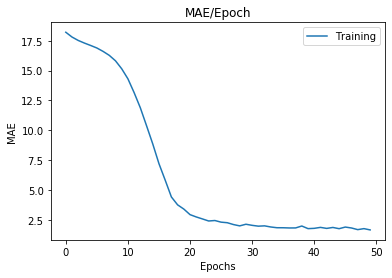

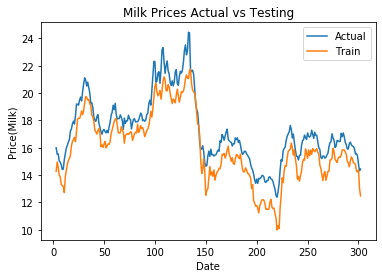

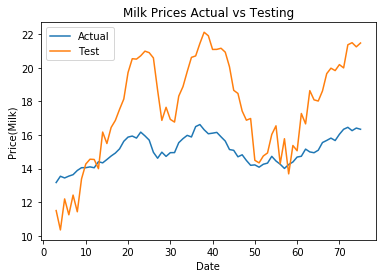

In [22]:
##### design network
model = Sequential()

#13
model.add(CuDNNLSTM(13, input_shape=(predictors_reshaped.shape[1:]), kernel_regularizer=l2(0.001), return_sequences=True))
model.add(BatchNormalization())

model.add(Dense(13, activation='linear', activity_regularizer=l2(0.01)))
model.add(Dropout(0.1))

model.add(CuDNNLSTM(7, input_shape=(predictors_reshaped.shape[1:]),activity_regularizer=l2(0.001), return_sequences=True))

model.add(Dense(13, activation='linear'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='linear'))

adam = keras.optimizers.Adam(lr=0.01)
sgd = keras.optimizers.sgd(lr=0.01, decay=-0.001, momentum=0.1)

model.compile(loss='mae', optimizer='adam')
earlystopping = EarlyStopping(patience=3)
# fit network
history = model.fit(predictors_reshaped, target_reshaped, epochs=50, verbose=False)

# plot history
plt.plot(history.history['loss'], label='Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE/Epoch')
plt.legend()
plt.show();

train_pred = model.predict(predictors_reshaped)
train_pred = train_pred.reshape((train_pred.shape[0], 1))

plt.figure()
plt.plot(target.index, target, label='Actual')
plt.plot(target.index, train_pred, label='Train')
plt.xlabel('Date')
plt.ylabel('Price(Milk)')
plt.title('Milk Prices Actual vs Testing')
plt.legend()
plt.show;


test_pred = model.predict(test_predictors_reshaped)
test_pred = test_pred.reshape((test_pred.shape[0], 1))

plt.figure()
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, test_pred, label='Test')
plt.xlabel('Date')
plt.ylabel('Price(Milk)')
plt.title('Milk Prices Actual vs Testing')
plt.legend()
plt.show;
